In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

imgs_path = glob.glob('./data/base/*.jpg')
annos_path = glob.glob('./data/base/*.png')

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize(mean=0.5, std=0.5)
])

class CMP_dataset(data.Dataset):
    def __init__(self,imgs_path, annos_path):
        self.imgs_path = imgs_path
        self.annos_path = annos_path

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        pil_img = Image.open(img_path)
        pil_img = transforms(pil_img)

        anno_path = self.annos_path[index]
        anno_img = Image.open(anno_path)
        anno_img = anno_img.convert("RGB")
        pil_anno = transforms(anno_img)

        return pil_anno, pil_img

    def __len__(self):
        return len(self.imgs_path)

dataset = CMP_dataset(imgs_path, annos_path)
BATCHSIZE = 16
dataloader = data.DataLoader(dataset,
                             batch_size = BATCHSIZE,
                             shuffle = True)
annos_batch, imgs_batch = next(iter(dataloader))


#  创建模型
#  定义下采样模块，也就是卷积模块
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1),
                            nn.LeakyReLU(inplace=True)
        )

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, is_bn=True):
        x = self.conv_relu(x)
        if is_bn:
            x = self.bn(x)
        return x

#  定义上采样模块
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upconv_relu = nn.Sequential(
                              nn.ConvTranspose2d(in_channels, out_channels,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1),  # 反卷积放大两倍
                            nn.LeakyReLU(inplace=True)
        )

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, is_drop=False):
        x = self.upconv_relu(x)
        x = self.bn(x)
        if is_drop:
            x = F.dropout2d(x)
        return x

# 定义生成器： 包含6个下采样层。5个上采样层，一个输出层（也是上采样）
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = Downsample(3, 64)           # 3,256.256 ——> 64, 128, 128
        self.down2 = Downsample(64, 128)         # 128, 64, 64
        self.down3 = Downsample(128, 256)        # 256, 32, 32
        self.down4 = Downsample(256, 512)        # 512, 16, 16
        self.down5 = Downsample(512, 512)        # 512, 8, 8
        self.down6 = Downsample(512, 512)        # 512, 4, 4

        self.up1 = Upsample(512, 512)            # 512, 8, 8
        self.up2 = Upsample(1024, 512)           # 512, 16, 16
        self.up3 = Upsample(1024, 256)           # 256, 32, 32
        self.up4 = Upsample(512, 128)            # 128, 64, 64
        self.up5 = Upsample(256, 64)             # 64, 128, 128

        # 输出层不需要Upsample里的LeakyReLU激活，也不需要BatchNorm2d，所以单独定义一个
        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1)   # 3,256,256
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)

        x6 = self.up1(x6, is_drop=True)
        x6 = torch.cat([x6, x5], dim=1)

        x6 = self.up2(x6, is_drop=True)
        x6 = torch.cat([x6, x4], dim=1)

        x6 = self.up3(x6, is_drop=True)
        x6 = torch.cat([x6, x3], dim=1)

        x6 = self.up4(x6)
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.up5(x6)
        x6 = torch.cat([x6, x1], dim=1)

        x6 = torch.tanh(self.last(x6))

        return x6

# 判别器的代码  输入anno+img(生成或者真实)  concat  -->
# 对比不同的输出结果，1*70*70是比较好的结果
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.down1 = Downsample(6, 64)         # 6是anno, img进行结合，64*128*128
        self.down2 = Downsample(64, 128)       # 128*64*64
        self.conv1 = nn.Conv2d(128, 256, 3)    # 不再进行下采样，因为期望的是1*70*70，和64*64差不多，所以使用Conv2d——> 256*64*64
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256, 1, 3)

    def forward(self, anno, img):
        x = torch.cat([anno, img], axis = 1)
        x = self.down1(x, is_bn=False)  # 输入不使用BN层，以免引起比较大的振荡

        x = self.down2(x)
        x = F.leaky_relu(self.conv1(x))
        x = F.dropout2d(self.bn(x))

        x = torch.sigmoid(self.last(x))

        return x
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator().to(device)
dis = Discriminator().to(device)

d_optimizer = torch.optim.Adam(dis.parameters(),lr=0.001,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gen.parameters(),lr=0.001,betas=(0.5,0.999))

def generate_images(model, test_input, true_target):
    prediction = model(test_input).permute(0, 2, 3, 1).detach().cpu().numpy()
    test_input = test_input.permute(0, 2, 3, 1).cpu().numpy()
    true_target = true_target.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], true_target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# 加载测试图片
test_imgs_path = glob.glob('./data/extended/*.jpg')
test_annos_path = glob.glob('./data/extended/*.png')

test_dataset = CMP_dataset(test_imgs_path, test_annos_path)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = BATCHSIZE)
test_annos_batch, test_imgs_batch = next(iter(test_dataloader))
test_annos_batch, test_imgs_batch = test_annos_batch.to(device), test_imgs_batch.to(device)

# 定义损失函数
# CGAN损失
loss_fn = torch.nn.BCELoss()
# L1损失在训练过程中计算

1.0
(1024, 584)


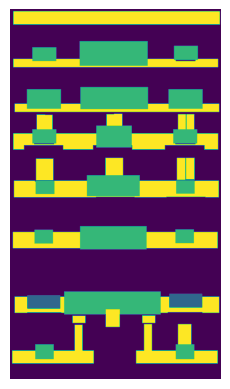

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 读取图像
image_path = r"./data/base/cmp_b0006.png"
image = plt.imread(image_path)[:,:,0]
# image = np.array(Image.open(image_path))[:,:,1]
print(np.max(image))
print(image.shape)

# 显示图像
plt.imshow(image)
plt.axis('off')
plt.show()

255
(1024, 682)


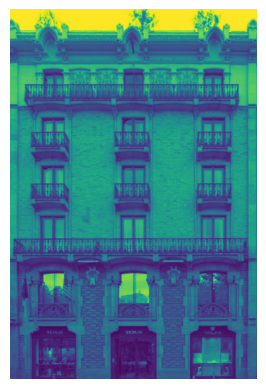

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 读取图像
image_path = r"./data/base/cmp_b0005.jpg"
image = plt.imread(image_path)[:,:,0]
# image = np.array(Image.open(image_path))[:,:,1]
print(np.max(image))
print(image.shape)

# 显示图像
plt.imshow(image)
plt.axis('off')
plt.show()